# __Part A: Convolutional Neural Network__

<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __Previously__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

1. Exploratory data analysis was done
2. Original, 31 x 31 and 128 x 128 images was all analysed

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__Import Libraries__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import all the necessary libraries

In [1]:
# !unzip 1.zip

In [2]:
%pip install tensorflow_addons keras-tuner pandas matplotlib seaborn scikit-learn tqdm efficientnet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Other Imports

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, accuracy_score

import os, time, math, datetime, warnings, pytz, glob
from IPython.display import display
from functools import reduce
import absl.logging
from tqdm import tqdm
import logging
from efficientnet.tfkeras import EfficientNetB3

absl.logging.set_verbosity(absl.logging.ERROR)
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings('ignore')

### Tensorflow Import

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow import expand_dims
from tensorflow.keras import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.image import random_flip_left_right, random_crop, resize_with_crop_or_pad
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, Input, InputLayer, Normalization, Flatten,BatchNormalization,
    Dropout,Conv2D, GlobalAveragePooling2D, MaxPooling2D, ReLU, Layer,Activation, Multiply, AveragePooling2D,
    Add, RandomRotation,Resizing, Rescaling, Reshape, Concatenate, concatenate, Lambda,LeakyReLU, ZeroPadding2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN, TensorBoard, CSVLogger, Callback
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad, Adamax
from tensorflow.keras.regularizers import l2, L2
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.metrics import FalseNegatives, categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import *
from tensorflow_addons.optimizers import SWA
from tensorflow.keras import layers

from kerastuner.tuners import Hyperband
from kerastuner import RandomSearch
from kerastuner import HyperModel
# Setting a seaborn style
sns.set(style="whitegrid")


### Set the seed of this notebook

In [5]:
seed = 32
tf.random.set_seed(seed)
np.random.seed(seed)

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__Check for GPU__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is check the available GPUs and set the memory growth

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [7]:
!nvidia-smi

Sat Nov 25 23:41:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0 Off |                  Off |
|  0%   37C    P2              54W / 450W |   1309MiB / 24564MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Import dataset__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import the dataset and proceed to do analysis on it

### 128 x 128 Images

#### Train Data

In [8]:
data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/train'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
data_big

Found 9028 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
X_train_big = []
y_train_big = []

for images, labels in tqdm(data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_train_big.append(images)
    y_train_big.append(labels)

X_train_big = np.concatenate(X_train_big, axis=0)
X_train_big = np.squeeze(X_train_big, axis=-1)
y_train_big = np.concatenate(y_train_big, axis=0)

100%|██████████| 283/283 [00:01<00:00, 155.81it/s]


#### Validation Data

In [10]:
val_data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/validation'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
val_data_big

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
X_val_big = []
y_val_big = []

for images, labels in tqdm(val_data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_val_big.append(images)
    y_val_big.append(labels)

X_val_big = np.concatenate(X_val_big, axis=0)
X_val_big = np.squeeze(X_val_big, axis=-1)
y_val_big = np.concatenate(y_val_big, axis=0)

100%|██████████| 94/94 [00:00<00:00, 201.32it/s]


#### Test Data

In [12]:
test_data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/test'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
test_data_big

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
X_test_big = []
y_test_big = []

for images, labels in tqdm(test_data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_test_big.append(images)
    y_test_big.append(labels)

X_test_big = np.concatenate(X_test_big, axis=0)
X_test_big = np.squeeze(X_test_big, axis=-1)
y_test_big = np.concatenate(y_test_big, axis=0)

100%|██████████| 94/94 [00:00<00:00, 202.43it/s]


In [14]:
labels_dict = os.listdir('Dataset for CA1 part A/train')
labels_dict = {idx: label for idx, label in enumerate(labels_dict)}
print(labels_dict)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __Data Preprocessing (Basic)__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here we will do the basic data preprocessing

### Mean Normalisation

This is a data preprocessing technique that scales the values of a feature to a specific range, to 0 and 1.

$$
X_{} = \frac{x_{} - μ_{}}{σ_{}}
$$

Where:
- `X` is the scaled value after normalisation
- `x` is the original value of the feature
- `μ` is the mean value
- `σ` is the standard deviation

This ensures that all the data will have the same influence with it beiung on the similar scale

In [15]:
preprocess = Normalization()
preprocess.adapt(X_train_big)
after = tf.squeeze(preprocess(X_train_big[:1,:,:]))
after

<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[ 0.41177738,  0.6600891 ,  0.9634177 , ..., -0.66415495,
         0.01610002,  0.04657318],
       [ 0.78619844,  1.0653405 ,  0.72406304, ..., -0.8666236 ,
        -0.9397956 , -0.13165802],
       [ 0.81559473,  0.99619013,  0.62705195, ..., -1.0218626 ,
        -0.13560566,  0.479111  ],
       ...,
       [-1.715268  , -1.6797397 , -1.5521767 , ..., -1.7130822 ,
        -1.6788731 , -1.6350837 ],
       [-1.6704276 , -1.6929415 , -1.5875094 , ..., -1.6836725 ,
        -1.6623827 , -1.6295879 ],
       [-1.7040095 , -1.6908416 , -1.6120721 , ..., -1.649799  ,
        -1.6432748 , -1.6361306 ]], dtype=float32)>

#### Comparing the difference

We will visualsie the difference to check whether it has 

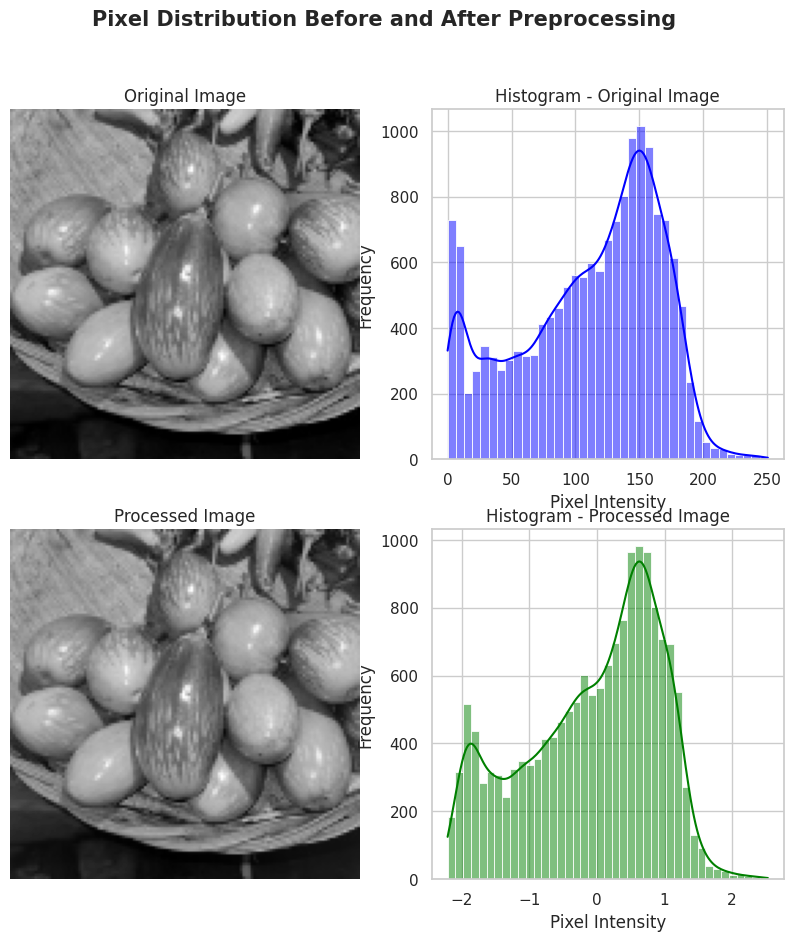

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Pixel Distribution Before and After Preprocessing', fontsize=15, fontweight='bold')

ax[0, 0].set_title('Original Image')
ax[0, 0].imshow(X_train_big[0].astype(np.uint8), cmap='gray') 
ax[0, 0].axis('off')  

ax[0, 1].set_title('Histogram - Original Image')
sns.histplot(X_train_big[0].flatten(), ax=ax[0, 1], color='blue', kde=True)
ax[0, 1].set_xlabel('Pixel Intensity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].grid(True)

ax[1, 0].set_title('Processed Image')
ax[1, 0].imshow(after, cmap='gray')  
ax[1, 0].axis('off')

ax[1, 1].set_title('Histogram - Processed Image')
sns.histplot(after.numpy().flatten(), ax=ax[1, 1], color='green', kde=True)
ax[1, 1].set_xlabel('Pixel Intensity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].grid(True)

plt.show()

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
 
- Above, we can see how the image look after utilising data preprocessing mean normlisation
</div>

### Encoding
- Tensorflow to categorical fuunction helps tonverts the data into integer of 0 and 1 similar to that of a one hot encoding
- We will proceed to encode the y into one hot encoding with training

In [17]:
y_train_big = to_categorical(y_train_big)
y_val_big = to_categorical(y_val_big)

#### Check on the encoding shape here|

In [18]:
y_train_big.shape, y_val_big.shape

((9028, 15), (3000, 15))

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
 
- The one hot encoding is done accurately with 15 classes for each y labels
</div>

<a class="anchor" id="2"></a>
## <font color='#71a1e3'>__WandDB__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Store the model into a cloud service

In [19]:
!pip install wandb -qU

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [20]:
import wandb
wandb.login()
# 6f7550f0407bb56d822df6618b5721c40a68a3dd

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ruizhuo168 (111da). Use `wandb login --relogin` to force relogin


True

In [21]:
from wandb.keras import WandbCallback

<a class="anchor" id="2"></a>
## <font color='#71a1e3'>__Required Functions__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">



### Loss and Accuracy Curve

1. Loss Curve:
   - Calculates the actual difference between the model's prediction and the actual true output
   - By minimising the loss, the model aims to make its predictions as close as possible to the true value
   - Shows us the loss over iterations
   - ![Loss Curve](https://api.wandb.ai/files/mostafaibrahim17/images/projects/37042936/4cdebc09.png)
3. Accuracy Curve:
   - This us how good the model is at making correct predictions on the training data as it goes through the training process.
   - It is measured in percentages and tells us the proportion of instances the model correctly classified out of the total number of instances
   - Tells us how well the model fit with the data
   - ![Accuracy Curve](https://api.wandb.ai/files/mostafaibrahim17/images/projects/37042936/4cdebc09.png)

In [22]:
def plot_model_history(model_history):
    history_df = pd.DataFrame(model_history)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(history_df['loss'], 'g--', label='Training Loss')
    axs[0].plot(history_df['val_loss'], 'b-', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    if 'accuracy' in history_df and 'val_accuracy' in history_df:
        axs[1].plot(history_df['accuracy'], 'g--', label='Training Accuracy')
        axs[1].plot(history_df['val_accuracy'], 'b-', label='Validation Accuracy')
        axs[1].set_title('Training and Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        axs[1].grid(True)

    plt.tight_layout()
    plt.close(fig)

    def show():
        display(fig)

    return show

### Setting up the parameters

In [23]:
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
val_split = 0.2
max_epochs = 100


In [24]:
base_hparams = {"val_split" : val_split, "max_epochs" : max_epochs,"batch_size" : 16}
steps_per_epoch = np.ceil(len(X_train_big) / 128)
steps_per_epoch

71.0

### Evluator

- Evaluator class will handle the data and history 
- Training of model
- Return history and defined callbacks

In [25]:
class Evaluator:
  def __init__(self, path=None, project_name="CNN_CA1"):
      # Initialize wandb
      self.project_name = project_name

      # Your existing initialization code
      if path:
          self.result = pd.read_csv(path, sep=';')
      else:
          cols = ['Model Name', 'Batch Size', "Train Loss", "Test Loss", "Train Acc", "Test Acc", "Remarks"]
          self.result = pd.DataFrame(columns=cols)

      self.callback = [
          TerminateOnNaN()
      ]
      # self.api = wandb.Api()

  def train_model(self, model, train, val, hyperparameters, callbacks):
    tf.keras.backend.clear_session()
    epochs = hyperparameters['max_epochs']
    batch_size = 64

    if val is None:
      X_train, y_train = train
      return model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split = hyperparameters["val_split"], callbacks=callbacks).history
    else:
      return model.fit(train, validation_data = val, epochs = epochs, batch_size = batch_size , callbacks=callbacks).history

  def model_evaluate(self, train, val, model, hyperparameters, callbacks=None, plot_loss=True, remarks=""):
      tf.keras.backend.clear_session()
      # wandb.init(project=self.project_name)
      callbacks = (callbacks or [EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5)]) + self.callback
      history = self.train_model(model, train, val, hyperparameters, callbacks)
      bestval_index = np.argmax(history['val_accuracy'])


      if plot_loss:
          try:
              fig = plot_model_history(history)
          except Exception as e:
              print(e, 'here')
              print("error creating loss curve")
              fig = None

      result = {
          "Model Name": model.name,
          "Epochs": len(history["loss"]),
          "Batch Size": hyperparameters["batch_size"],
          "Train Loss": history["loss"][bestval_index],
          "Test Loss": history["val_loss"][bestval_index],
          "Train Acc": history["accuracy"][bestval_index],
          "Test Acc": history["val_accuracy"][bestval_index]
      }
      # wandb.log({
      #     "Model Name": model.name,
      #     "Epochs": len(history["loss"]),
      #     "Batch Size": hyperparameters["batch_size"],
      #     "Train Loss": history["loss"][bestval_index],
      #     "Test Loss": history["val_loss"][bestval_index],
      #     "Train Acc": history["accuracy"][bestval_index],
      #     "Test Acc": history["val_accuracy"][bestval_index],
      # })

      # wandb.finish()
      return result, fig

  def _train_model(self, model, training_data, validation_data, hyperparameters, callbacks):
      tf.keras.backend.clear_session()
      epochs = hyperparameters["max_epochs"]
      batch_size = hyperparameters["batch_size"]

      if validation_data is None:
          X_train, y_train = training_data
          return model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=hyperparameters["val_split"], callbacks=callbacks).history

      return model.fit(training_data, validation_data=validation_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks).history


  def return_history(self, project_name='CNN_CA1', entity=None, include_cols=None):
      if include_cols is None:
          include_cols = ['Model Name', 'Epochs', 'Batch Size', 'Train Loss','Test Loss','Train Acc','Test Acc','Remarks']

      runs = self.api.runs('111da/CNN_CA1')
      # List to store results
      results = []

      for run in runs:
          run_summary = run.summary
          data = {}
          for col in include_cols:
              data[col] = run_summary.get(col, None)
          results.append(data)
      df = pd.DataFrame(results)

      return df


  def remove_model(self, model_name):
      self.result = self.result[self.result["Model Name"] != model_name]


### Evaluation Function

-  Below is a function for evluation
- Dataframe with classification report showing different evaluation metric

In [26]:
def evaluation_test(model, X_val, y_val, LABELS):
    final_predictions = model.predict(X_val)
    final_predictions_final = np.argmax(final_predictions, axis=1)
    y_test_final = np.argmax(y_val, axis=1) if y_val.ndim == 2 else y_val
    classification_results = classification_report(y_test_final, final_predictions_final, target_names=LABELS.values(), output_dict=True)

    # Print Accuracy
    print('Accuracy:', accuracy_score(y_test_final, final_predictions_final))
    result = pd.DataFrame(classification_results).transpose().sort_values('f1-score')
    return result


### HeatMap Visualisation

- This function is too visualise heatmap
- The graph will show the different scores

In [27]:
def plot_classification_heatmap(df):
    heatmap_data = df.drop(['accuracy', 'macro avg', 'weighted avg']).iloc[:, :-1]
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues")
    plt.title("Classification Report Heatmap")
    plt.show()


<a class="anchor" id="2"></a>
## <font color='#71a1e3'>__Evaluation Metrics__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Below are the evaluation metrics that I am going to be using

### Accuracy

- Measure of how often the model correctly predicts the label of input data

### Validation Accuracy

- This is similar to accuracy but is calculate on validation data to show us how weel the model is doing

### Loss

- Measure of the error between predicted and actual values (Eg: Categoryical Cross entropy)

### Validation Loss

- Similar to Loss but test on validation set to show how is the model doing

### Confusuion Matrix on F1-Score, Precision, Recall

- Includes a summary of how well the model is doling with respect to classes and diferent evaluation metric in classification task

### Cohen Kappa 

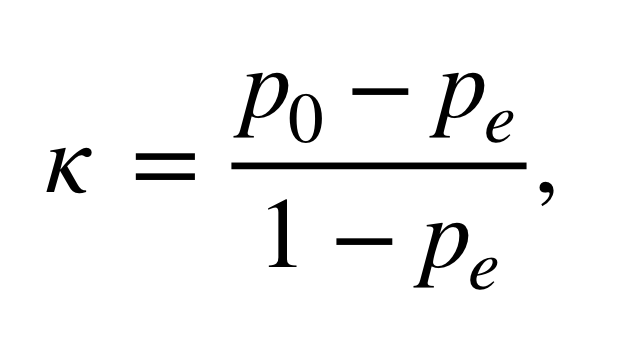

- Statistical Analysis that adjust for the agreement
  
    - Values ≤ 0 suggest no agreement
    - 0.01–0.20 indicates slight agreement
    - 0.21–0.40 indicates fair agreement
    - 0.41–0.60 indicates moderate agreement
    - 0.61–0.80 indicates substantial agreement
    - 0.81–1.00 indicates almost perfect agreement
- Specifically useful for imbalance datasetment.

<a class="anchor" id="2"></a>
## <font color='#71a1e3'>__Baseline Model__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">


Here, we will creaate a few baseliune model

1. First part will be custom implementation
2. Second part will be implementation of trained models 

### Making the Train and Validation Data

In [28]:
no = lambda x : x
def data_before_train(self, aug_func=no):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big)).map(lambda x, y : (expand_dims(x, -1), y))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_big, y_val_big)).shuffle(128 * 100).batch(128).map(lambda x, y : (expand_dims(x, -1), y)).prefetch(tf.data.AUTOTUNE)
    train_ds = train_ds.map(lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE).shuffle(128 * 100).batch(128).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds
train_ds, val_ds = data_before_train(no)

### Making the results dataframe

In [29]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [30]:
columns = ["Model Name", "Epochs", "Batch Size", "Train Loss", "Test Loss", "Train Acc", "Test Acc",'Kappa', "Comments"]
overall = pd.DataFrame(columns=columns)
print(overall)


Empty DataFrame
Columns: [Model Name, Epochs, Batch Size, Train Loss, Test Loss, Train Acc, Test Acc, Kappa, Comments]
Index: []


### Dense Neural Network Model

**Input Type**
- **Configuration**: Shape (128, 128, 1)

**Flatten**
- **Purpose**: Flattens the 2D input image into a 1D array

**First, Second Third Dense Block**
- **Layer Type**: Dense with neurons 128 with activation ReLU
- **Layer Type**: BatchNormalization to normalises the activations from the previous layer, improving training stability
- **Layer Type**: LeakyReLU for additional non-linearity, often redundant after ReLU.
- **Layer Type**: Dropout Rate: 0.2 to prevents overfitting by randomly setting 20% of the inputs to zero.

**Fourth Dense Block:**

- **Layer Type**: Dense with 64 neurons and activation: ReLU
- **Layer Type**: BatchNormalization
- **Layer Type**: LeakyReLU
- **Layer Type**: Dropout

**Output**
- **Layer Type**: Dense with 15 neurons and activation: Softmax

**Compilation**
- Optimizer: 'adam'.
- Loss Function: Categorical Crossentropy.
- Metrics: Accuracy.
ses, suitable for multi-class classification.
uracy as a performance metric

In [31]:
def baseline_model(optimizer='adam', name='Baseline_Dense_Model'):
    model = Sequential(name=name)

    model.add(Input(shape=(128, 128, 1)))
    model.add(preprocess)
    model.add(Flatten())

    # First Dense Block
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    # Second Dense block
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    # Third dense block
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    # Fourth dense block
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    # Output
    model.add(Dense(15, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

#### Setting up the evaluator

In [32]:
evaluator = Evaluator()

#### Running the model

In [33]:
model = baseline_model()
results_base, fig_base = evaluator.model_evaluate( train_ds, val_ds , model, base_hparams)

Model: "Baseline_Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 128, 128, 128)    257       
 n)                                                              
                                                                 
 flatten (Flatten)           (None, 2097152)           0         
                                                                 
 dense (Dense)               (None, 64)                134217792 
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)       

#### Analysing the graph

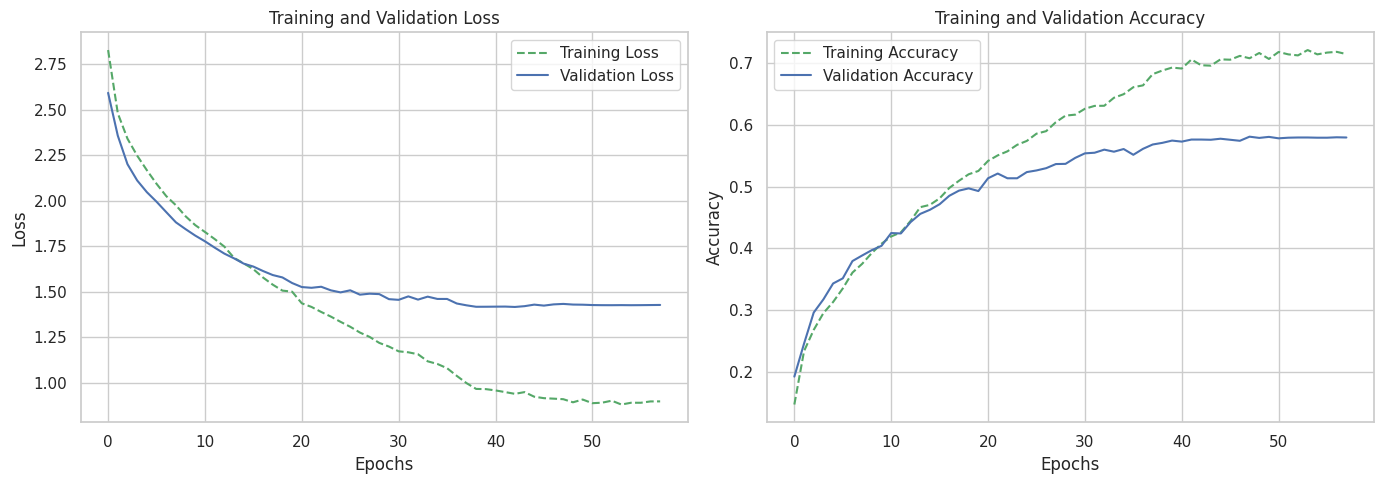

In [34]:
fig_base()

In [35]:
pd.Series(results_base)

Model Name    Baseline_Dense_Model
Epochs                          58
Batch Size                      16
Train Loss                0.910382
Test Loss                 1.433305
Train Acc                 0.707576
Test Acc                  0.580667
dtype: object

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Training and Validation loss
    - For the training loss, it starts relatively  high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the okatueay without increasing but a relatively higher loss

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a relatveily lower accuracy here
</div>

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [36]:
cls_df_base = evaluation_test(model, X_test_big, y_test_big, labels_dict)
cls_df_base

94/94 [==============================] - 0s 3ms/step
Accuracy: 0.5773333333333334


,precision,recall,f1-score,support
Potato,0.606557,0.370000,0.459627,200.000000
Tomato,0.365123,0.670000,0.472663,200.000000
Cabbage,0.545455,0.450000,0.493151,200.000000
Bean,0.460377,0.610000,0.524731,200.000000
Radish,0.661765,0.450000,0.535714,200.000000
Broccoli,0.557292,0.535000,0.545918,200.000000
Brinjal,0.482143,0.675000,0.562500,200.000000
accuracy,0.577333,0.577333,0.577333,0.577333
weighted avg,0.607429,0.577333,0.579087,3000.000000
macro avg,0.607429,0.577333,0.579087,3000.000000


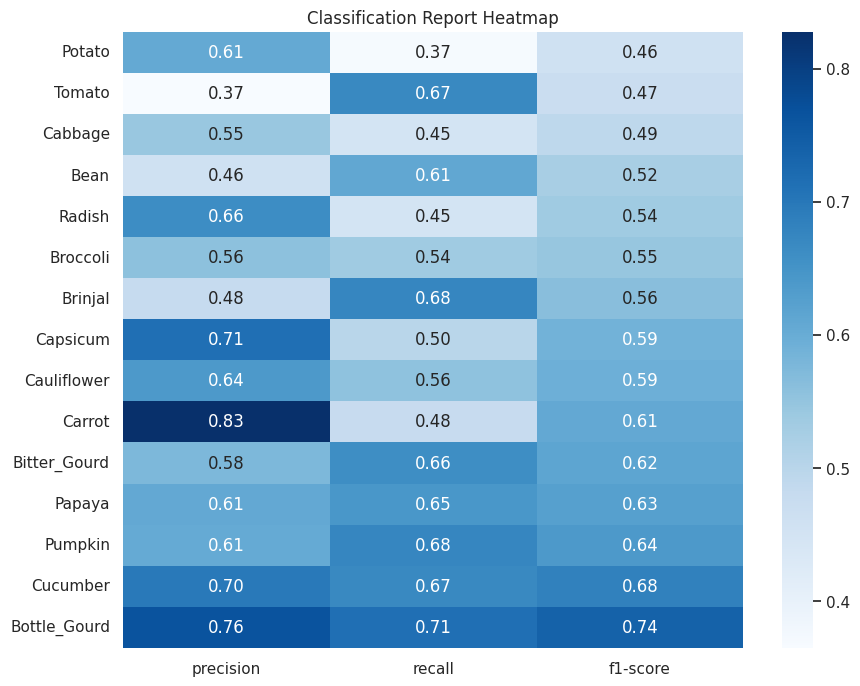

In [37]:
plot_classification_heatmap(cls_df_base)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is at 63%. In addition, the model is best at prediction Bottle Gourd and worst at Cabbage in terms of f1 score
</div>

#### Cohen Kappa Coefficient

In [38]:
y_pred = model.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_base = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_base)

94/94 [==============================] - 0s 3ms/step
Cohen’s Kappa Score: 0.5471428571428572


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the Cophen Kappa Coefficient, we can see that the model is reliable to certain extent as it is substantial agreement
</div>

Adding in the results to the overall dataframe

In [39]:
results_base['Kappa'] = kappa_base
overall = pd.concat([overall, pd.DataFrame([results_base])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,Baseline_Dense_Model,58,16,0.910382,1.433305,0.707576,0.580667,0.547143,NaN


### Convolutional Neural Network Model

**Input Layer**
- Configuration: Shape (128, 128, 1) for grayscale images.

**Convolutional Blocks**
- Three blocks with increasing filters (64, 128, 256), (3, 3) kernel size, 'same' padding, ReLU activa- Then  block followed by BatchNormalization, MaxPooling2D with (2, 2) pool size, and Dropout (0.3, 0.3, 0.4).

**Flattening**
- Transition from 3D output of Conv blocks to 1D array.

**Dense Layers**
- Two dense blocks with 512 and 128 neurons, ReLU activation, BatchNormalization, and Dropout (0.5 for both).

**Output Layer**
- Dense with 15 neurons, Softmax activation for multi-class classification.

**Compilation**
- Optimizer: 'adam'.
- Loss Function: Categorical Crossentropy.
- Metrics: Accuracy.
assified instances during training and evaluation.
assified instances during training and evaluation.

In [40]:
def baseline_model2(optimizer='adam', name='CNN_Baseline'):
    model = Sequential(name=name)

    # Input layer
    model.add(Input(shape=(128, 128, 1)))

    # First Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Convolutional Block
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    # Dense Block
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Dense Block
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(15, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

#### Running the model

In [41]:
cnn_model = baseline_model2()
results_cnn, fig_cnn = evaluator.model_evaluate( train_ds, val_ds , cnn_model, base_hparams)

Model: "CNN_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)     

#### Analysing the graph

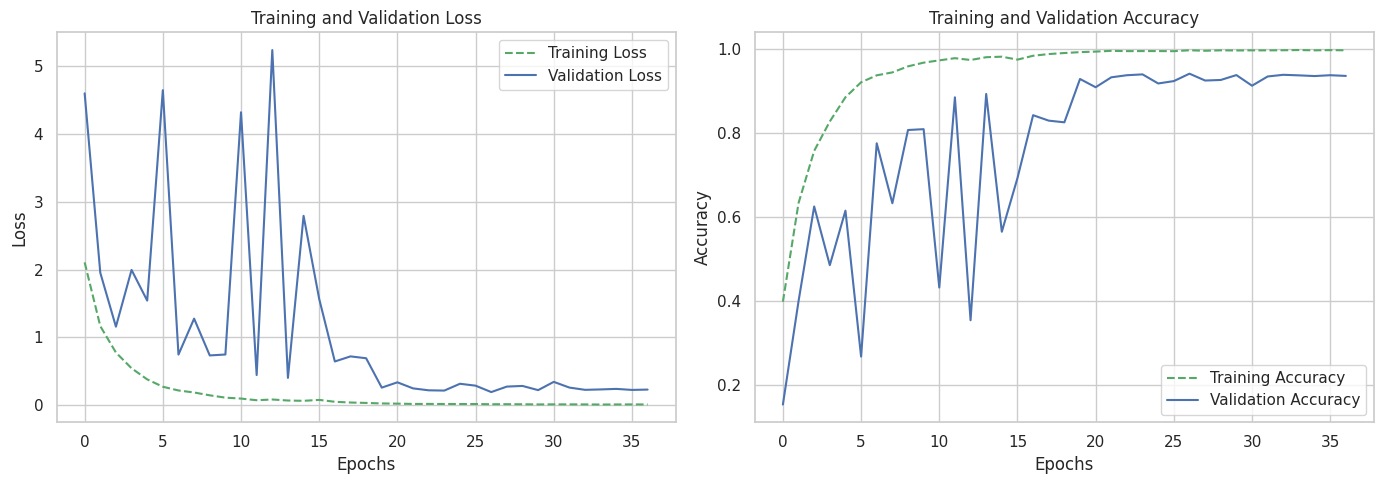

In [42]:
fig_cnn()

In [43]:
pd.Series(results_cnn)

Model Name    CNN_Baseline
Epochs                  37
Batch Size              16
Train Loss        0.013904
Test Loss         0.193325
Train Acc         0.997785
Test Acc             0.942
dtype: object

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the okatueay without increasing but a relatively higher loss but noticeble spikes were seen at the start before plateau and may have some form of overfitting

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a relatveily lower accuracy here and noticeable downward spikes which similarly could suggest overfitting
</div>

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [44]:
cls_df_cnn = evaluation_test(cnn_model, X_test_big, y_test_big, labels_dict)

94/94 [==============================] - 1s 4ms/step
Accuracy: 0.9573333333333334


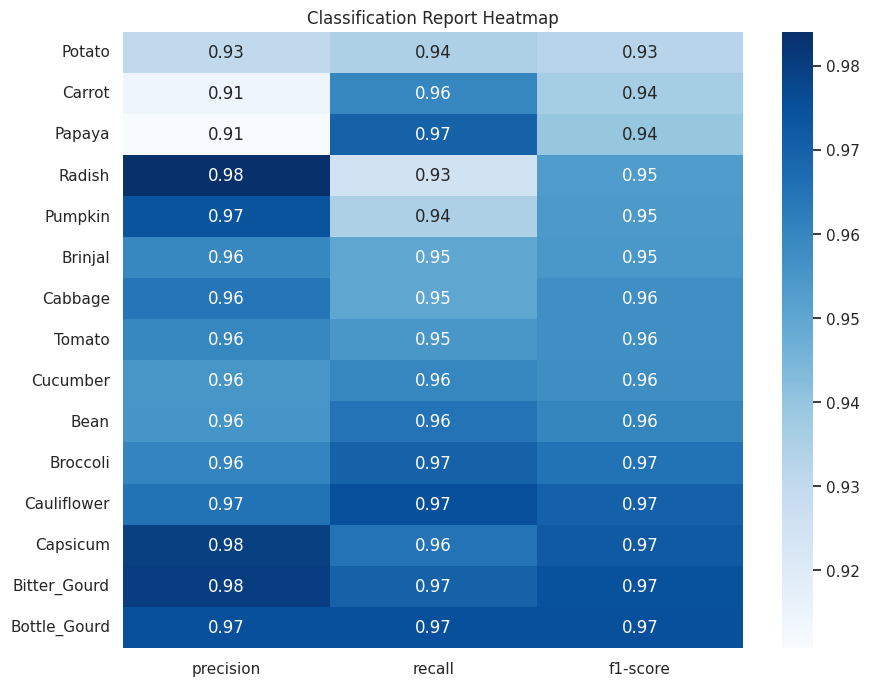

In [45]:
plot_classification_heatmap(cls_df_cnn)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is at 95%, similar to train accuracy hence no overfitting
- In addition, the model is best at prediction Bottle Gourd and worst at Tomato in terms of f1 score
</div>

### Cohen Kappa Coefficient

In [46]:
y_pred = cnn_model.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_cnn = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_cnn)

94/94 [==============================] - 0s 4ms/step
Cohen’s Kappa Score: 0.9542857142857143


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the Cophen Kappa Coefficient, we can see that the model is reliable and good

Adding results to dataframe

In [47]:
results_cnn['Kappa'] = kappa_cnn
overall = pd.concat([overall, pd.DataFrame([results_cnn])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,Baseline_Dense_Model,58,16,0.910382,1.433305,0.707576,0.580667,0.547143,NaN
1,CNN_Baseline,37,16,0.013904,0.193325,0.997785,0.942000,0.954286,NaN


### Baseline Model 3 Creation (Second CNN)

Compared to previous CNN
Input Layer
- **Configuration**: Accepts  `(128, 128, 1)`

First Few CNN Bock
- **Layers**: Starts with two convolutional layers with `32` and `64` filters respectively
- **Kernel Size**: Uses `(3, 3)` kernel size
- **Padding**: 'same' padding to maintain spatial dimensions
- **Normalization and Activation**: Each convolution is followed by batch normalization and ReLU activation

Additional Convolutional Blocks
- **Layers**: Four additional convolutional blocks, each with `128` filters
- **Kernel Size**: `(3, 3)` kernel size
- **Padding**: 'same' padding to avoid reduction in dimensionality
- **Normalization and Activation**: Followed by batch normalization and ReLU activation

Global Average Pooling
- **Layer**: GlobalAveragePooling2D is used to condense feature maps into a single vector per map

Dense Layers for Classification
- **Dense Layer**: Dense layer with `256` neurons and ReLU activation
- **Output Layer**: Final output layer with `15` neurons

Compilation
- **Optimizer**: Adam optimizer
- **Loss Function**: Categorical crossentropy, suitable for multi-class classification tasks
- **Metrics**: Accuracy is used to monitor the proportion of correctly classified instancesly classified instances.


In [48]:
!nvidia-smi

Sat Nov 25 23:46:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0 Off |                  Off |
| 70%   51C    P2             153W / 450W |  18467MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [49]:
def CNN2(name='CNN2_Baseline'):

    filters_list = [32, 64, 128, 128, 128, 128]

    model = Sequential()

    # Add initial convolutional layers
    model.add(Conv2D(filters=filters_list[0], kernel_size=(3, 3), padding='same', input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(filters=filters_list[1], kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    for filters in filters_list[2:]:
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(15, activation='softmax')) 

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


#### Running the model -- Reduce Complexity

In [50]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
cnn_model2 = CNN2()
results_cnn2, fig_cnn2 = evaluator.model_evaluate( train_ds, val_ds , cnn_model2, base_hparams)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 64)      0

#### Analysing the graph

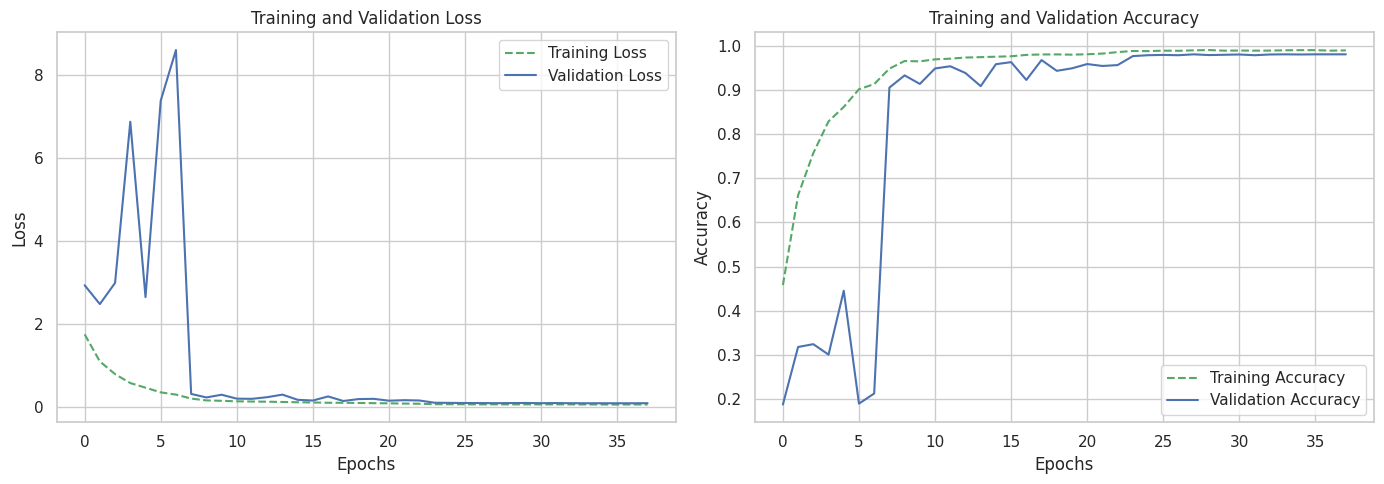

In [51]:
fig_cnn2()

In [52]:
pd.Series(results_cnn2)

Model Name    sequential
Epochs                38
Batch Size            16
Train Loss        0.0688
Test Loss       0.097689
Train Acc       0.989699
Test Acc        0.980667
dtype: object

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the okatueay without increasing but a relatively higher loss but noticeble spikes seen at the start but proceeds to consistent later on

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a relatveily lower accuracy here and noticeable downward spikes at the start before  steadily increasing
</div>

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [53]:
cls_df_cnn2 = evaluation_test(cnn_model2, X_test_big, y_test_big, labels_dict)

94/94 [==============================] - 2s 17ms/step
Accuracy: 0.979


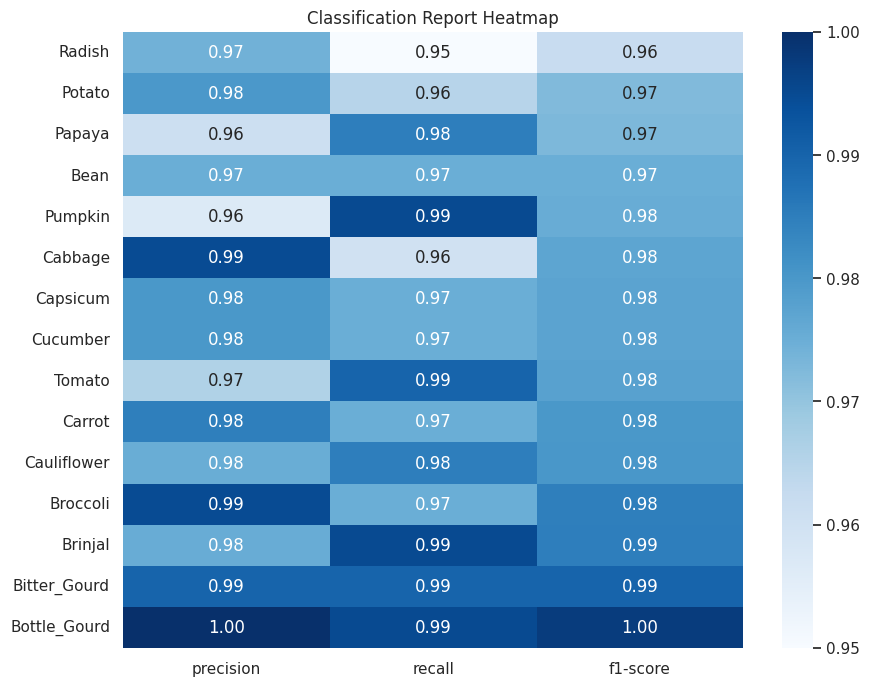

In [54]:
plot_classification_heatmap(cls_df_cnn2)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is at 97%, similar to train accuracy hence no overfitting
- In addition, the model is best at prediction Bottle Gourd and worst at Pumpkin in terms of f1 score
</div>

### Cohen Kappa Coefficient

In [55]:
y_pred = cnn_model2.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_cnn2 = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_cnn2)

94/94 [==============================] - 2s 16ms/step
Cohen’s Kappa Score: 0.9775


Adding results to dataframe

In [56]:
results_cnn2['Model Name'] = 'CNN_Baseline2'
results_cnn2['Kappa'] = kappa_cnn2
overall = pd.concat([overall, pd.DataFrame([results_cnn2])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,Baseline_Dense_Model,58,16,0.910382,1.433305,0.707576,0.580667,0.547143,NaN
1,CNN_Baseline,37,16,0.013904,0.193325,0.997785,0.942000,0.954286,NaN
2,CNN_Baseline2,38,16,0.068800,0.097689,0.989699,0.980667,0.977500,NaN


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the Cophen Kappa Coefficient, we can see that the model is reliable and good
</div>

### Baseline Model 4 Creation (Custom VGG16)

This is how it looks like

[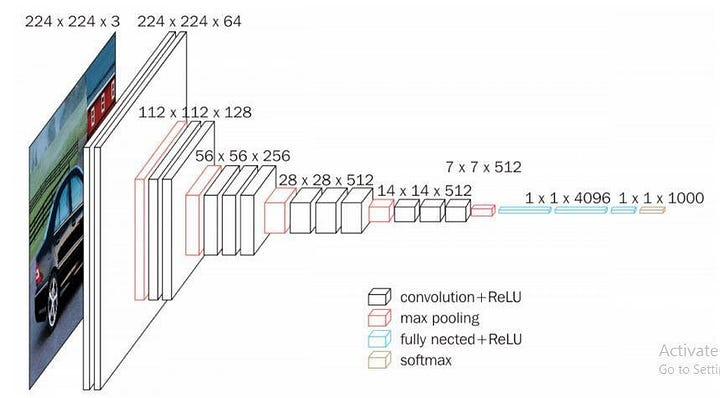]
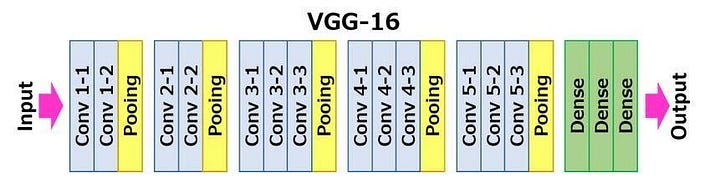


**Vgg Model 16: Developed by Cornell University**
- The 16 in VGG16 refers to 16 layers that have weights
- 13 convolutional layers, 5 Max Pooling layers, and 3 Dense layers which sum up to 21 layers but it has only 16 weight layers
-  takes input tensor size as 224, 244 with 3 RGB channel- I instead of having a large number of hyper-parameters they focused on having convolution layers of 3x3 filter with stride 1 and always used the same padding and maxpool layer of 2x2 filter of stride 
- Ce convolution and max pool layers are consistently arranged throughout the whole architecture
Conv-1 Layer has 64 number of filters, Conv-2 has 128 filters, Conv-3 has 256 filters, Conv 4 and Conv 5 has 512 fil
- 3Three Fully-Connected (FC) layers follow a stack of convolutional layers: the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each c


**My Implementation**
- Increase of layers
- Starts at a lower number of filters
- Change in conv block (reduce to 4 from 5)
- Added batch normliasation
- Added L2 regularisation
- Reduce the dropout ratelayer
- More Conv block will be added

In [57]:
def vgg_conv_layer(filters, kernel_size=3, activation='relu', weight_decay=WEIGHT_DECAY):
    return Sequential([
        Conv2D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        ReLU() if activation == 'relu' else activation
    ])

def vgg_conv_block(no_layers, filters, activation='relu'):
    block = Sequential()
    for _ in range(no_layers):
        block.add(vgg_conv_layer(filters, activation=activation))
    block.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    return block

class VGGNet(Model):
    def __init__(self, input_shape, num_classes, name='VGGNet_Baseline'):
        super(VGGNet, self).__init__(name=name)
        self.vgg_blocks = [
            vgg_conv_block(2, 32, activation='relu'),
            vgg_conv_block(3, 64, activation='relu'),
            vgg_conv_block(3, 128, activation='relu'),
            vgg_conv_block(3, 256, activation='relu'),
        ]
        self.global_pool = GlobalAveragePooling2D()
        self.classifier = Sequential([
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        x = inputs
        for block in self.vgg_blocks:
            x = block(x)
        x = self.global_pool(x)
        return self.classifier(x)

    def build(self, input_shape):
        inputs = Input(shape=(128,128,1))
        model = Model(inputs=inputs, outputs=self.call(inputs), name=self.name)
        return model

#### Starting the model

In [58]:
input_shape = (128, 128, 1)
num_classes = 15
vgg = VGGNet(input_shape, num_classes)
vgg_model = vgg.build(input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "VGGNet_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 32)        9824      
                                                                 
 sequential_3 (Sequential)   (None, 32, 32, 64)        93120     
                                                                 
 sequential_7 (Sequential)   (None, 16, 16, 128)       370560    
                                                                 
 sequential_11 (Sequential)  (None, 8, 8, 256)         1478400   
                                                                 
 global_average_pooling2d (G  (None, 256)              0         
 lobalAveragePooling2D)                                          
                                                   

#### Running the model

In [59]:
results_vgg, fig_vgg = evaluator.model_evaluate( train_ds, val_ds , vgg_model, base_hparams)

Epoch 1/100
71/71 [==============================] - 7s 72ms/step - loss: 3.8677 - accuracy: 0.2646 - val_loss: 53.3068 - val_accuracy: 0.0667 - lr: 0.0100
Epoch 2/100
71/71 [==============================] - 4s 60ms/step - loss: 2.3043 - accuracy: 0.4417 - val_loss: 4.0255 - val_accuracy: 0.1217 - lr: 0.0100
Epoch 3/100
71/71 [==============================] - 4s 61ms/step - loss: 2.0377 - accuracy: 0.4996 - val_loss: 5.8537 - val_accuracy: 0.1540 - lr: 0.0100
Epoch 4/100
71/71 [==============================] - 4s 60ms/step - loss: 1.8337 - accuracy: 0.5557 - val_loss: 3.4977 - val_accuracy: 0.1567 - lr: 0.0100
Epoch 5/100
71/71 [==============================] - 4s 61ms/step - loss: 1.7467 - accuracy: 0.5991 - val_loss: 3.9690 - val_accuracy: 0.1643 - lr: 0.0100
Epoch 6/100
71/71 [==============================] - 4s 60ms/step - loss: 1.6617 - accuracy: 0.6204 - val_loss: 3.6558 - val_accuracy: 0.1670 - lr: 0.0100
Epoch 7/100
71/71 [==============================] - 4s 60ms/step - l

#### Analysing the graph

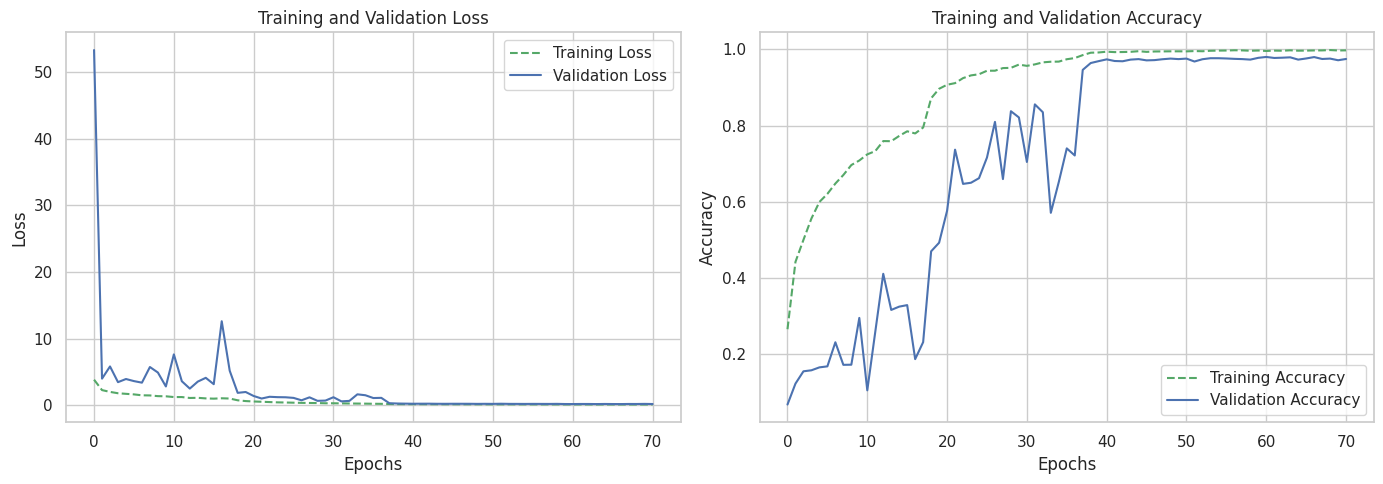

In [60]:
fig_vgg()

In [61]:
pd.Series(results_vgg)

Model Name    VGGNet_Baseline
Epochs                     71
Batch Size                 16
Train Loss           0.157832
Test Loss            0.213377
Train Acc            0.996012
Test Acc             0.980333
dtype: object

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with small spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a relatveily lower accuracy here and noticeable downward spikes which similarly could suggest overfitting
</div>

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [62]:
cls_df_vgg = evaluation_test(vgg_model, X_test_big, y_test_big, labels_dict)
cls_df_vgg

94/94 [==============================] - 1s 4ms/step
Accuracy: 0.984


,precision,recall,f1-score,support
Cauliflower,0.979899,0.975,0.977444,200.000
Broccoli,0.979899,0.975,0.977444,200.000
Bean,0.961353,0.995,0.977887,200.000
Pumpkin,0.975248,0.985,0.980100,200.000
Capsicum,0.994872,0.970,0.982278,200.000
Tomato,0.980100,0.985,0.982544,200.000
accuracy,0.984000,0.984,0.984000,0.984
macro avg,0.984098,0.984,0.984006,3000.000
weighted avg,0.984098,0.984,0.984006,3000.000
Bitter_Gourd,0.989899,0.980,0.984925,200.000


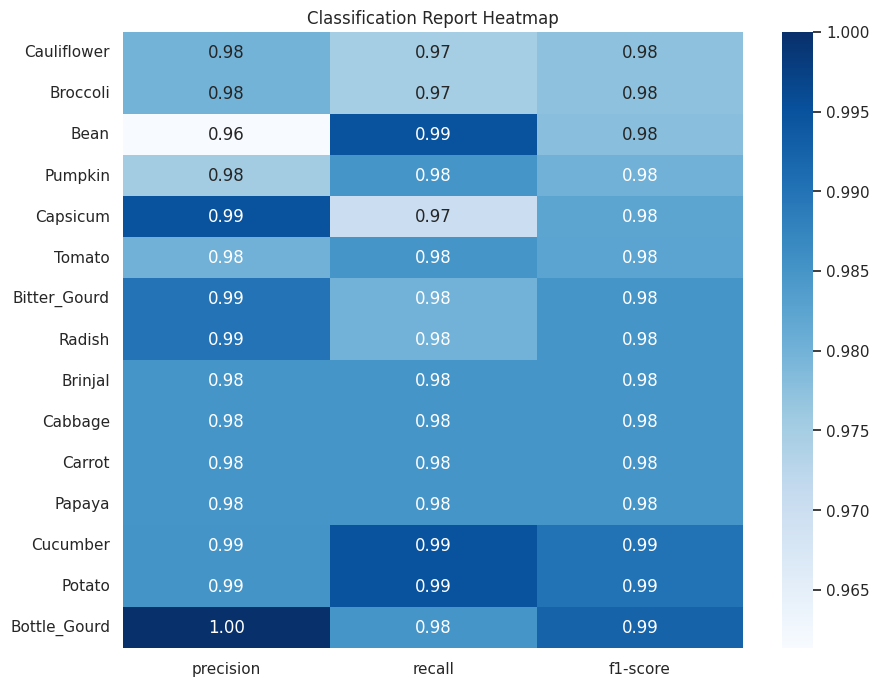

In [63]:
plot_classification_heatmap(cls_df_vgg)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is at 95%, similar to train accuracy hence no overfitting
- In addition, the model is best at prediction Bottle Gourd and worst at Cauliflower in terms of f1 score
</div>

#### Cohen Kappa Coefficient

In [64]:
y_pred = vgg_model.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_vgg = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_vgg)

94/94 [==============================] - 0s 3ms/step
Cohen’s Kappa Score: 0.9828571428571429


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the Cophen Kappa Coefficient, we can see that the model is reliable to certain extent as it is substantial agreement
</div>

Adding results to dataframe

In [65]:
results_vgg['Kappa'] = kappa_vgg
overall = pd.concat([overall, pd.DataFrame([results_vgg])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,Baseline_Dense_Model,58,16,0.910382,1.433305,0.707576,0.580667,0.547143,NaN
1,CNN_Baseline,37,16,0.013904,0.193325,0.997785,0.942000,0.954286,NaN
2,CNN_Baseline2,38,16,0.068800,0.097689,0.989699,0.980667,0.977500,NaN
3,VGGNet_Baseline,71,16,0.157832,0.213377,0.996012,0.980333,0.982857,NaN


### Baseline Model 4 Creation (Custom AlexNet Template)

Below is how alex net look like

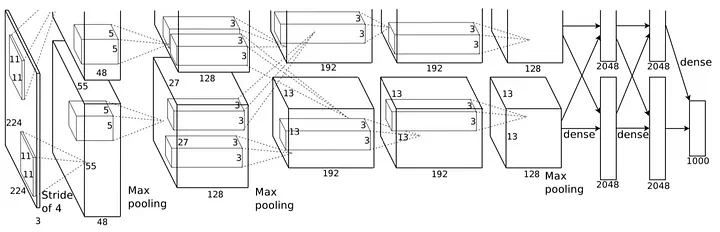

**AlexNet: Developed by Universit of Toronto**
- Consists of 8 layers with weights: 5 convolutional layers followed by 3 fully connected layers
- Accepts input image of 227 x 227 x 3
- First CNN has 06 kernels of size 11 x 11 and stride 4
- Second uses 256 and 5x5 with the rest being 384, 384 and 256 with 3x3 in size respectively
- Relu was used
- 4096 neurons for each of the last year layers

**My Implementation**
- Suited for one colour channel
- Change in the number of strides from 4 to 2
- Change in second layer size
- Batch Normalisation was added

In [66]:
def alexNet(optimizer='adam', name='AlexNet_Baseline'):
    model = Sequential(name=name)

    # Input Layer
    model.add(Input(shape=(128, 128, 1)))

    # First convolutional Block
    model.add(Conv2D(filters=96, kernel_size=(3,3), strides=(2,2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(BatchNormalization())

    # Second convolutional Block
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(BatchNormalization())

    # Three consecutive convolutional Block
    model.add(Conv2D(filters=384, kernel_size=(2,2), padding="same", activation='relu'))
    model.add(Conv2D(filters=384, kernel_size=(2,2), padding="same", activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(2,2), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(BatchNormalization())

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=15, activation='softmax')) # Assuming 15 classes as in your previous model

    # Compile the model
    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

#### Running the model

In [67]:
alexnet = alexNet()
results_alex, fig_alex = evaluator.model_evaluate( train_ds, val_ds , alexnet, base_hparams)

Model: "AlexNet_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 256)       221440    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                  

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

#### Analysing the graph

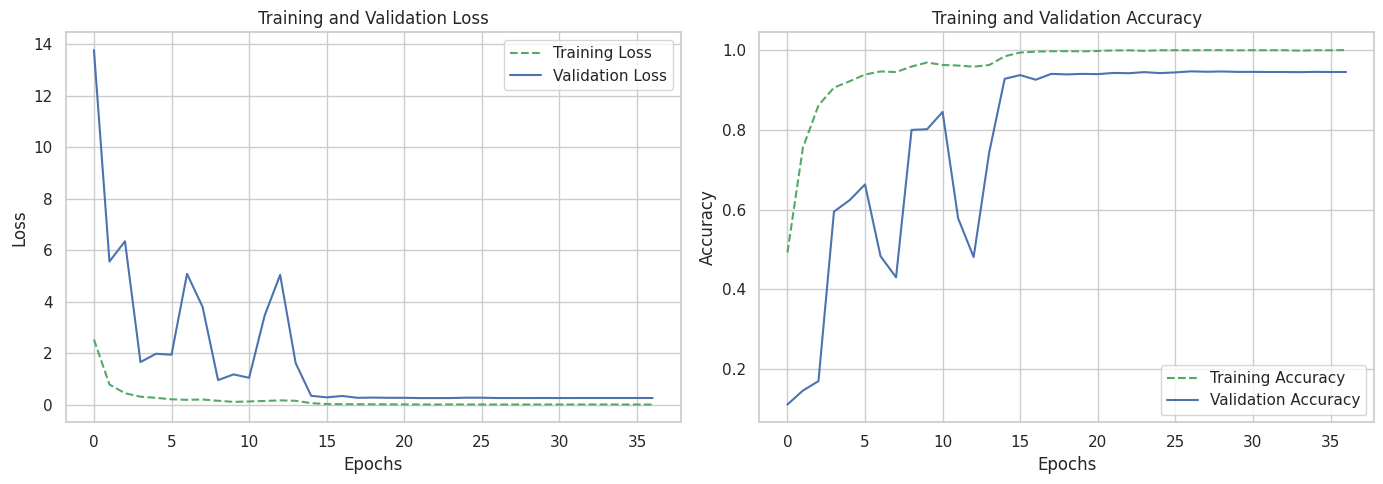

In [68]:
fig_alex()

In [69]:
pd.Series(results_alex)

Model Name    AlexNet_Baseline
Epochs                      37
Batch Size                  16
Train Loss            0.003087
Test Loss             0.254574
Train Acc             0.999114
Test Acc              0.946333
dtype: object

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with small spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a lower accuracy here and noticeable downward spikes which similarly could suggest overfitting
</div>

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [70]:
cls_df_alex = evaluation_test(alexnet, X_test_big, y_test_big, labels_dict)
cls_df_alex

94/94 [==============================] - 1s 3ms/step
Accuracy: 0.9483333333333334


,precision,recall,f1-score,support
Tomato,0.893720,0.925000,0.909091,200.000000
Cauliflower,0.916667,0.935000,0.925743,200.000000
Potato,0.952632,0.905000,0.928205,200.000000
Brinjal,0.906977,0.975000,0.939759,200.000000
Carrot,0.953846,0.930000,0.941772,200.000000
Cabbage,0.949495,0.940000,0.944724,200.000000
Radish,0.978610,0.915000,0.945736,200.000000
accuracy,0.948333,0.948333,0.948333,0.948333
macro avg,0.948929,0.948333,0.948360,3000.000000
weighted avg,0.948929,0.948333,0.948360,3000.000000


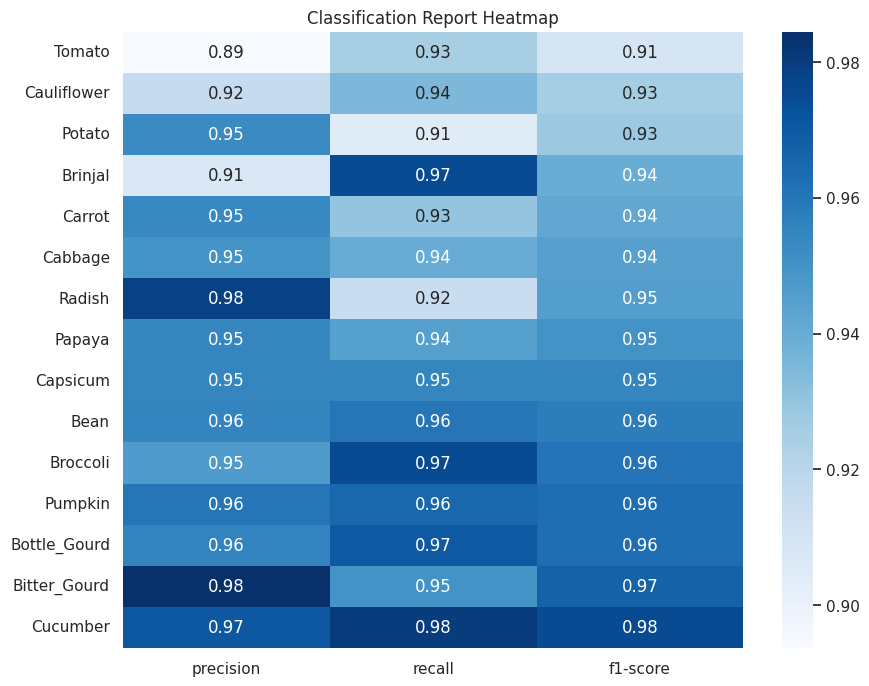

In [71]:
plot_classification_heatmap(cls_df_alex)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is at 89%, similar to train accuracy hence no overfitting
- In addition, the model is best at prediction Bottle Gourd and worst at Tomato in terms of f1 score
</div>

#### Cohen Kappa Coefficient

In [72]:
y_pred = alexnet.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_alex = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_alex)

94/94 [==============================] - 0s 3ms/step
Cohen’s Kappa Score: 0.9446428571428571


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the Cophen Kappa Coefficient, we can see that the model is reliable to certain extent as it is substantial agreement
</div>

Adding results to dataframe

In [73]:
results_alex['Kappa'] = kappa_alex
overall = pd.concat([overall, pd.DataFrame([results_alex])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,Baseline_Dense_Model,58,16,0.910382,1.433305,0.707576,0.580667,0.547143,NaN
1,CNN_Baseline,37,16,0.013904,0.193325,0.997785,0.942000,0.954286,NaN
2,CNN_Baseline2,38,16,0.068800,0.097689,0.989699,0.980667,0.977500,NaN
3,VGGNet_Baseline,71,16,0.157832,0.213377,0.996012,0.980333,0.982857,NaN
4,AlexNet_Baseline,37,16,0.003087,0.254574,0.999114,0.946333,0.944643,NaN


### Baselin Model 5 Creation (WideRestNet Template)

This is how RestNet looks like:

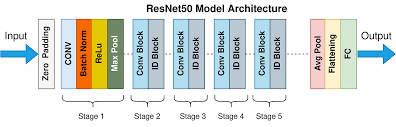

RestNet Idea:
- Bottleneck strucutre is used to reduce model parameters by alternating 1x1 and 3x3 covolutions
- Extract features at decreasing levels of resolution from conv2_x to conv5_x
- Stride=2 is used in the first 3x3 convolutions of the first residual blocks for conv3_x, conv4_x, and conv5_x to downsample feature maps to get larger receptive field.

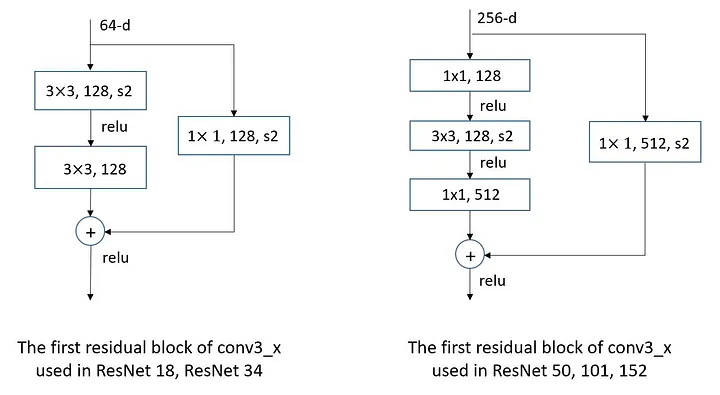

**My Implementation**
- Change the input size suitable for the 31 x 31 images

In [74]:
def res_conv(x, s, filters):
    x_skip = x
    f1, f2 = filters

    # First block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # Shortcut
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # Add and activation
    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

def res_identity(x, filters):
    x_skip = x 
    f1, f2 = filters

    # First block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second block - bottleneck (but size kept the same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third block - activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # Add the input
    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

def resnet50(train_im, class_types):
    input_im = Input(shape=(128,128,1))  
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # 2nd stage
    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage
    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage
    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage
    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # Ends with average pooling and dense connection
    x = AveragePooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x)  # Multi-class

    # Define the model
    model = Model(inputs=input_im, outputs=x, name='Resnet50')
   
    model.summary()
    return model

#### Running the model

In [75]:
restnet_model = resnet50(X_train_big, labels_dict)
restnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
restnet_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']          

In [76]:
results_restnet, fig_restnet = evaluator.model_evaluate( train_ds, val_ds , restnet_model, base_hparams)

Epoch 1/100
71/71 [==============================] - 12s 100ms/step - loss: 21.0908 - accuracy: 0.2210 - val_loss: 28728.5156 - val_accuracy: 0.0663 - lr: 0.0010
Epoch 2/100
71/71 [==============================] - 6s 80ms/step - loss: 16.3218 - accuracy: 0.4461 - val_loss: 15.4803 - val_accuracy: 0.1700 - lr: 0.0010
Epoch 3/100
71/71 [==============================] - 6s 79ms/step - loss: 12.5275 - accuracy: 0.6297 - val_loss: 237.6957 - val_accuracy: 0.0607 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - 6s 80ms/step - loss: 9.8702 - accuracy: 0.7416 - val_loss: 10.4473 - val_accuracy: 0.3313 - lr: 0.0010
Epoch 5/100
71/71 [==============================] - 6s 79ms/step - loss: 8.1733 - accuracy: 0.7755 - val_loss: 8.1964 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 6/100
71/71 [==============================] - 6s 80ms/step - loss: 6.6748 - accuracy: 0.8619 - val_loss: 6.8496 - val_accuracy: 0.6263 - lr: 0.0010
Epoch 7/100
71/71 [==============================] - 6s 7

#### Analysing the graph

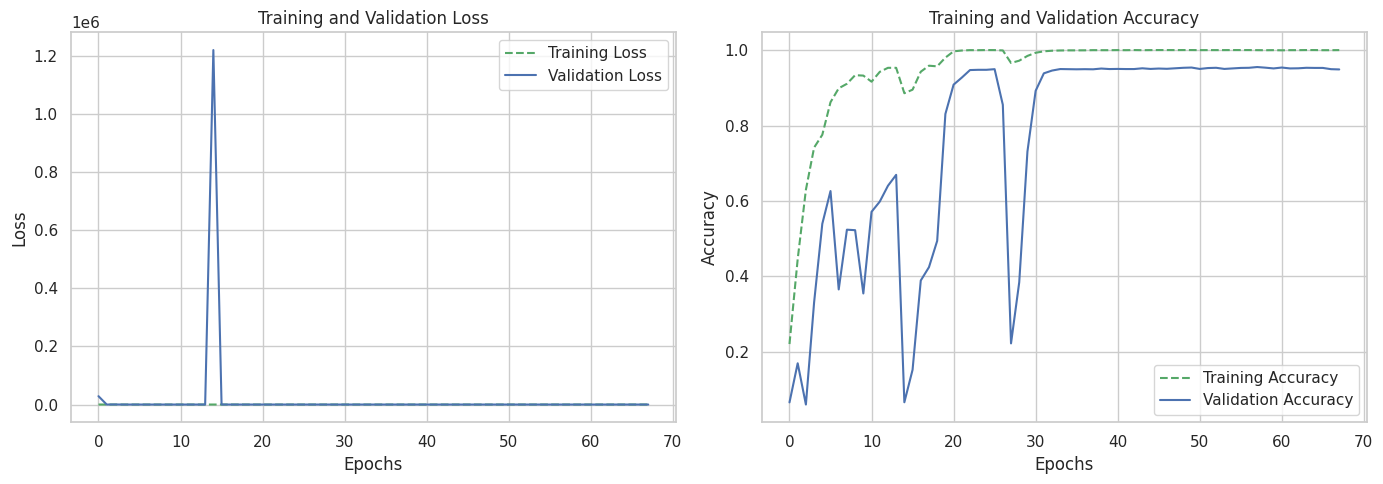

In [77]:
fig_restnet()

In [78]:
pd.Series(results_restnet)

Model Name    Resnet50
Epochs              68
Batch Size          16
Train Loss     1.44712
Test Loss     1.647934
Train Acc     0.999778
Test Acc         0.955
dtype: object

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with small spikes and a huge increase at the end showng overfitting

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning with some spikes
    - For the validation accuracy, similar pattern is seen but with a relatveily lower accuracy here and noticeable downward spikes which  suggest overfitting
</div>

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [79]:
cls_df_restnet= evaluation_test(restnet_model, X_test_big, y_test_big, labels_dict)
cls_df_restnet


94/94 [==============================] - 2s 11ms/step
Accuracy: 0.9576666666666667


,precision,recall,f1-score,support
Brinjal,0.886364,0.975000,0.928571,200.000000
Cabbage,0.953608,0.925000,0.939086,200.000000
Tomato,0.948980,0.930000,0.939394,200.000000
Potato,0.954082,0.935000,0.944444,200.000000
Pumpkin,0.959391,0.945000,0.952141,200.000000
Carrot,0.959596,0.950000,0.954774,200.000000
Broccoli,0.955000,0.955000,0.955000,200.000000
Capsicum,0.969231,0.945000,0.956962,200.000000
accuracy,0.957667,0.957667,0.957667,0.957667
weighted avg,0.958231,0.957667,0.957716,3000.000000


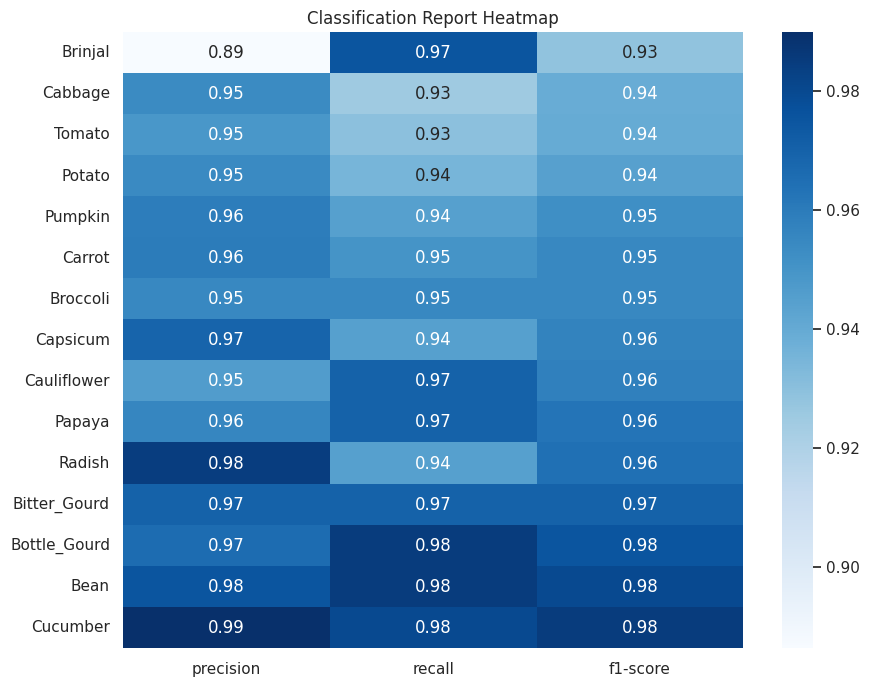

In [80]:
plot_classification_heatmap(cls_df_restnet)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is at 72%, worst than train accuracy hence no overfitting
- In addition, the model is best at prediction Bottle Gourd and worst at Potato in terms of f1 score
</div>

#### Cohen Kappa Coefficient

In [81]:
y_pred = restnet_model.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_restnet = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_restnet)

94/94 [==============================] - 1s 10ms/step
Cohen’s Kappa Score: 0.9546428571428571


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the Cophen Kappa Coefficient, we can see that the model is reliable to certain extent as it is substantial agreement
</div>

In [82]:
results_restnet['Kappa'] = kappa_restnet
overall = pd.concat([overall, pd.DataFrame([results_restnet])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,Baseline_Dense_Model,58,16,0.910382,1.433305,0.707576,0.580667,0.547143,NaN
1,CNN_Baseline,37,16,0.013904,0.193325,0.997785,0.942000,0.954286,NaN
2,CNN_Baseline2,38,16,0.068800,0.097689,0.989699,0.980667,0.977500,NaN
3,VGGNet_Baseline,71,16,0.157832,0.213377,0.996012,0.980333,0.982857,NaN
4,AlexNet_Baseline,37,16,0.003087,0.254574,0.999114,0.946333,0.944643,NaN
5,Resnet50,68,16,1.447120,1.647934,0.999778,0.955000,0.954643,NaN


### Efficient Net (Transfer Learning)

Below is how efficient net looks like

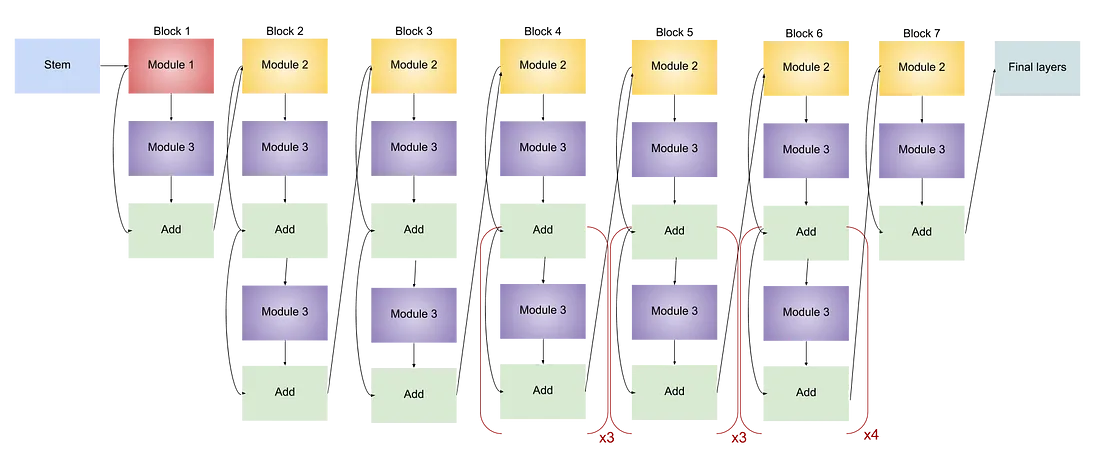

Efficient Net:
- Network is fine-tuned for obtaining maximum accuracy but is also penalised if the network is very computationally heavy
- Also penalised for slow inference time when the network takes a lot of time to make predictions. The architecture uses a mobile inverted bottleneck convolution similar to MobileNet V2 but is much larger due to the increase in FLOP
- This baseline model is scaled up to obtain the family of EfficientNet

**My Implementation**
- Added two more dense layers
- Change the input image into gray scale

In [83]:
def convert(x):
    return tf.tile(x, [1, 1, 1, 3])

input_layer = Input(shape=(128, 128, 1))
replicated_channels = Lambda(convert)(input_layer)

efficient_net = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    pooling='max'
)(replicated_channels)

x = Dense(units=120, activation='relu')(efficient_net)
x = Dense(units=120, activation='relu')(x)
output = Dense(15, activation='softmax')(x)


efficient = Model(inputs=input_layer, outputs=output)
efficient.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
efficient.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 efficientnet-b3 (Functional  (None, 1536)             10783528  
 )                                                               
                                                                 
 dense (Dense)               (None, 120)               184440    
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 15)                1815      
                                                             

#### Running the model

In [84]:
results_efficient, fig_efficient = evaluator.model_evaluate( train_ds, val_ds , efficient, base_hparams)

Epoch 1/100
71/71 [==============================] - 27s 225ms/step - loss: 0.0885 - accuracy: 0.8234 - val_loss: 0.3960 - val_accuracy: 0.5437 - lr: 0.0010
Epoch 2/100
71/71 [==============================] - 14s 193ms/step - loss: 0.0045 - accuracy: 0.9928 - val_loss: 0.0206 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 3/100
71/71 [==============================] - 14s 193ms/step - loss: 0.0037 - accuracy: 0.9935 - val_loss: 0.0099 - val_accuracy: 0.9780 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - 14s 193ms/step - loss: 0.0041 - accuracy: 0.9928 - val_loss: 0.0127 - val_accuracy: 0.9757 - lr: 0.0010
Epoch 5/100
71/71 [==============================] - 14s 191ms/step - loss: 0.0044 - accuracy: 0.9919 - val_loss: 0.0072 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 6/100
71/71 [==============================] - 14s 192ms/step - loss: 0.0032 - accuracy: 0.9940 - val_loss: 0.0074 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 7/100
71/71 [==============================] - 14s 1

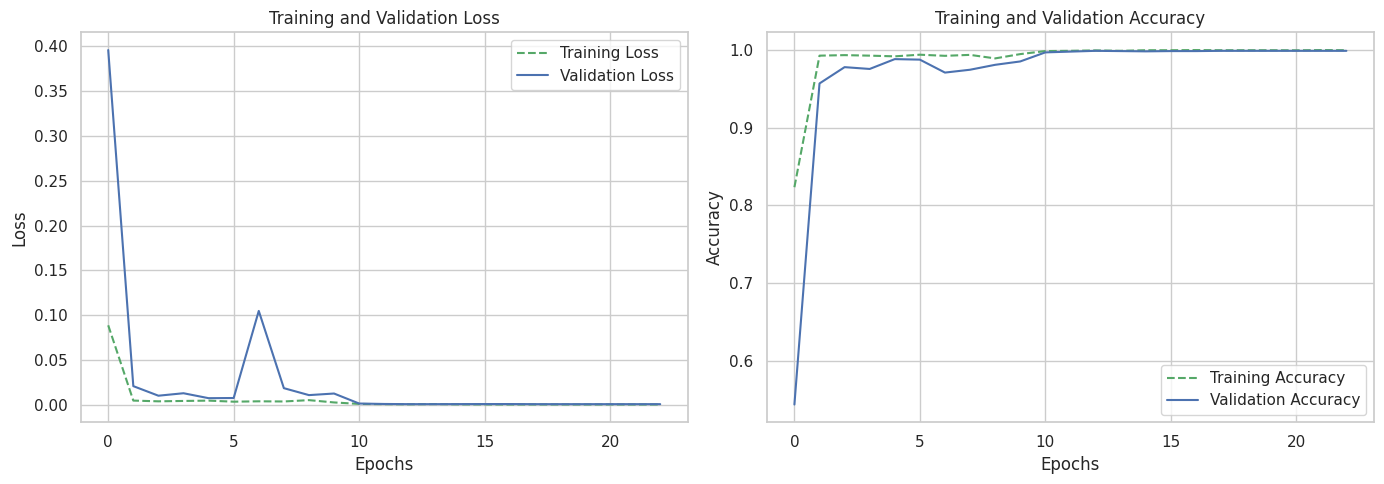

In [85]:
fig_efficient()

In [86]:
pd.Series(results_efficient)

Model Name       model
Epochs              23
Batch Size          16
Train Loss    0.000292
Test Loss     0.000503
Train Acc     0.999557
Test Acc         0.999
dtype: object

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes
</div>

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [87]:
cls_df_efficient = evaluation_test(efficient, X_test_big, y_test_big, labels_dict)
cls_df_efficient

94/94 [==============================] - 3s 20ms/step
Accuracy: 0.9976666666666667


,precision,recall,f1-score,support
Broccoli,0.994975,0.990000,0.992481,200.000000
Cauliflower,0.995000,0.995000,0.995000,200.000000
Cabbage,0.995000,0.995000,0.995000,200.000000
Bitter_Gourd,1.000000,0.995000,0.997494,200.000000
Tomato,1.000000,0.995000,0.997494,200.000000
Pumpkin,1.000000,0.995000,0.997494,200.000000
Bean,0.995025,1.000000,0.997506,200.000000
Brinjal,0.995025,1.000000,0.997506,200.000000
Bottle_Gourd,0.995025,1.000000,0.997506,200.000000
Capsicum,0.995025,1.000000,0.997506,200.000000


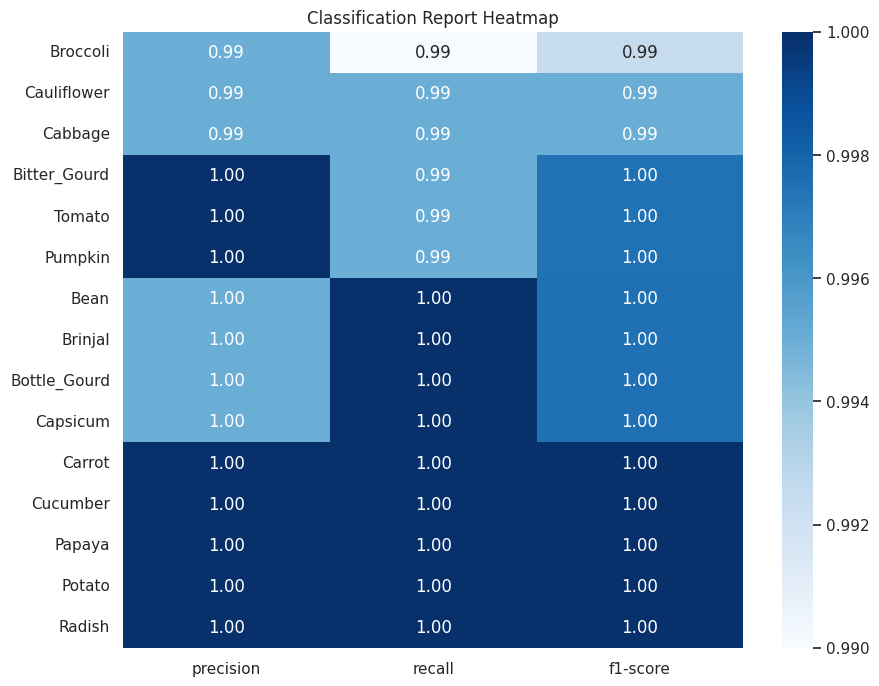

In [88]:
plot_classification_heatmap(cls_df_efficient)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is at 96.5%, similar to train accuracy hence no overfitting
- In addition, the model is best at prediction Bottle Gourd and worst at Pumpkin in terms of f1 score
</div>

#### Cohen Kappa Coefficient

In [89]:
y_pred = efficient.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_efficient = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_efficient)

94/94 [==============================] - 2s 17ms/step
Cohen’s Kappa Score: 0.9975


Adding results to dataframe

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the Cophen Kappa Coefficient, we can see that the model is reliable at 96.2
</div>

Adding results to dataframe

In [90]:
results_efficient['Model Name'] = 'EfficientNet (Transfer Learning)'
results_efficient['Kappa'] = kappa_efficient
overall = pd.concat([overall, pd.DataFrame([results_efficient])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,Baseline_Dense_Model,58,16,0.910382,1.433305,0.707576,0.580667,0.547143,NaN
1,CNN_Baseline,37,16,0.013904,0.193325,0.997785,0.942000,0.954286,NaN
2,CNN_Baseline2,38,16,0.068800,0.097689,0.989699,0.980667,0.977500,NaN
3,VGGNet_Baseline,71,16,0.157832,0.213377,0.996012,0.980333,0.982857,NaN
4,AlexNet_Baseline,37,16,0.003087,0.254574,0.999114,0.946333,0.944643,NaN
5,Resnet50,68,16,1.447120,1.647934,0.999778,0.955000,0.954643,NaN
6,EfficientNet (Transfer Learning),23,16,0.000292,0.000503,0.999557,0.999000,0.997500,NaN


In [91]:
overall.sort_values(by='Test Loss', inplace=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
6,EfficientNet (Transfer Learning),23,16,0.000292,0.000503,0.999557,0.999000,0.997500,NaN
2,CNN_Baseline2,38,16,0.068800,0.097689,0.989699,0.980667,0.977500,NaN
1,CNN_Baseline,37,16,0.013904,0.193325,0.997785,0.942000,0.954286,NaN
3,VGGNet_Baseline,71,16,0.157832,0.213377,0.996012,0.980333,0.982857,NaN
4,AlexNet_Baseline,37,16,0.003087,0.254574,0.999114,0.946333,0.944643,NaN
0,Baseline_Dense_Model,58,16,0.910382,1.433305,0.707576,0.580667,0.547143,NaN
5,Resnet50,68,16,1.447120,1.647934,0.999778,0.955000,0.954643,NaN


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Overall, I will use, Efficient Net baseline, Vgg Net Baseline and the 2 cnn baseline 
</div>

In [92]:
overall.to_csv('BaselineModel (128x128).csv')

### Continue....